In [28]:
import matplotlib.pyplot as plt
import numpy as np

from abc import abstractmethod
from itertools import accumulate
import random
from typing import Protocol
import math

In [9]:
class KArmedBandit(Protocol):
    @abstractmethod
    def arms(self) -> list[str]:
        raise NotImplementedError

    @abstractmethod
    def reward(self, arm: str) -> float:
        raise NotImplementedError


class BanditLearner(Protocol):
    name: str
    color: str

    @abstractmethod
    def reset(self, arms: list[str], time_steps: int):
        raise NotImplementedError

    @abstractmethod
    def pick_arm(self) -> str:
        raise NotImplementedError

    @abstractmethod
    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [10]:
class BanditProblem:
    def __init__(self, time_steps: int, bandit: KArmedBandit, learner: BanditLearner):
        self.time_steps: int = time_steps
        self.bandit: KArmedBandit = bandit
        self.learner: BanditLearner = learner
        self.learner.reset(self.bandit.arms(), self.time_steps)

    def run(self) -> list[float]:
        rewards = []
        for _ in range(self.time_steps):
            arm = self.learner.pick_arm()
            reward = self.bandit.reward(arm)
            self.learner.acknowledge_reward(arm, reward)
            rewards.append(reward)
        return rewards

In [11]:
def get_random_best_index(rewards):
    max_val = max(rewards)
    return random.choice([i for i, val in enumerate(rewards) if val == max_val])

In [12]:
POTENTIAL_HITS = {
    "April Showers": 0.5,
    "In Praise of Dreams": 0.8,
    "We Built This City": 0.9,
    "Twenty Four Hours": 0.3,
    "Dirge for November": 0.1,
}

In [13]:
class TopHitBandit(KArmedBandit):
    def __init__(self, potential_hits: dict[str, float]):
        self.potential_hits: dict[str, float] = potential_hits

    def arms(self) -> list[str]:
        return list(self.potential_hits)

    def reward(self, arm: str) -> float:
        thumb_up_probability = self.potential_hits[arm]
        return 1.0 if random.random() <= thumb_up_probability else 0.0

In [14]:
class RandomLearner(BanditLearner):
    def __init__(self):
        self.name = "Random"
        self.color = "black"
        self.arms: list[str] = []

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms

    def pick_arm(self) -> str:
        return random.choice(self.arms)

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [15]:
class ExploreThenCommitLearner(BanditLearner):
    def __init__(self, explore_time = 5):
        self.name = f"ExploreThenCommit m={explore_time}"
        self.color = "green"
        self.explore_time = explore_time
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.best_arm: str | None = None
        self.rewards: list[float] = []
        self.total_time = 0

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.best_arm = None
        self.rewards = [0 for _ in range(len(self.arms))]
        self.total_time = 0

    def pick_arm(self) -> str:
        if self.total_time < self.explore_time * len(self.arms):
            arm = self.arms[self.total_time % len(self.arms)]
            return arm
        
        if self.best_arm is None:
            self.best_arm = self.arms[get_random_best_index(self.rewards)]
        
        return self.best_arm

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.total_time += 1
        self.rewards[self.arms_indexes[arm]] += reward

In [70]:
class GreedyLearner(BanditLearner):
    def __init__(self, explore_probability = 0.1, arm_start_val = 0):
        self.name = f"Greedy exp={explore_probability}, start_val={arm_start_val}"
        self.color = "red"
        self.explore_probability = explore_probability
        self.arm_start_val = arm_start_val
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.arms_usage_counter: list[int] = []


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [self.arm_start_val for _ in range(len(self.arms))]
        self.arms_usage_counter = [0 for _ in range(len(self.arms))]


    def pick_arm(self) -> str:
        if random.random() < self.explore_probability:
            return random.choice(self.arms)
        
        return self.arms[get_random_best_index(self.rewards)]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        arm_index = self.arms_indexes[arm]
        self.arms_usage_counter[arm_index] += 1
        current_reward = self.rewards[arm_index]
        self.rewards[arm_index] += (reward - current_reward) / self.arms_usage_counter[arm_index]

In [69]:
class UCBLearner(BanditLearner):
    def __init__(self, c=0):
        self.name = f"UCB {c=}"
        self.color = "blue"
        self.c = c
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.total_time = 0
        self.arms_usage_counter: list[int] = []


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [0 for _ in range(len(self.arms))]
        self.total_time = 0
        self.arms_usage_counter = [0 for _ in range(len(self.arms))]


    def pick_arm(self) -> str:
        self.total_time += 1
        
        if self.total_time <= len(self.arms):
            return self.arms[self.total_time - 1]
        
        rewards_t = self.rewards[:]
        for i in range(len(rewards_t)):
            rewards_t[i] += self.c * math.sqrt(math.log(self.total_time) / self.arms_usage_counter[i])
        
        return self.arms[get_random_best_index(rewards_t)]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        arm_index = self.arms_indexes[arm]
        self.arms_usage_counter[arm_index] += 1
        current_reward = self.rewards[arm_index]
        self.rewards[arm_index] += (reward - current_reward) / self.arms_usage_counter[arm_index]

In [97]:
class ThompsonLearner(BanditLearner):
    def __init__(self, alpha=1, beta=1):
        self.name = f"Thompson {alpha=}, {beta=}"
        self.color = "lawngreen"
        self.alpha = alpha
        self.beta = beta
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.total_time = 0
        self.alpha_tab: list[float] = []
        self.beta_tab: list[float] = []


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [0 for _ in range(len(self.arms))]
        self.total_time = 0
        self.alpha_tab = [self.alpha for _ in range(len(self.arms))]
        self.beta_tab = [self.beta for _ in range(len(self.arms))]


    def pick_arm(self) -> str:
        self.total_time += 1
        
        best_arm = 0
        best_arm_val = float("-inf")
        for i in range(len(self.arms)):
            sample = np.random.beta(self.alpha_tab[i], self.beta_tab[i])
            if best_arm_val < sample:
                best_arm_val = sample
                best_arm = i
                
        return self.arms[best_arm]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        arm_index = self.arms_indexes[arm]
        self.alpha_tab[arm_index] += reward
        self.beta_tab[arm_index] += 1 - reward

In [17]:
def evaluate_learner(learner: BanditLearner) -> None:
    runs_results = []
    for _ in range(TRIALS_PER_LEARNER):
        bandit = TopHitBandit(POTENTIAL_HITS)
        problem = BanditProblem(time_steps=TIME_STEPS, bandit=bandit, learner=learner)
        rewards = problem.run()
        accumulated_rewards = list(accumulate(rewards))
        runs_results.append(accumulated_rewards)

    runs_results = np.array(runs_results)
    mean_accumulated_rewards = np.mean(runs_results, axis=0)
    std_accumulated_rewards = np.std(runs_results, axis=0)
    plt.plot(mean_accumulated_rewards, label=learner.name, color=learner.color)
    plt.fill_between(
        range(len(mean_accumulated_rewards)),
        mean_accumulated_rewards - std_accumulated_rewards,
        mean_accumulated_rewards + std_accumulated_rewards,
        color=learner.color,
        alpha=0.2,
    )

In [18]:
TIME_STEPS = 1000
TRIALS_PER_LEARNER = 50

In [130]:
learners = [
    RandomLearner(),
    ExploreThenCommitLearner(20),
    GreedyLearner(explore_probability=0, arm_start_val=1),
    UCBLearner(c=0.25),
    ThompsonLearner(2, 2)
        ]

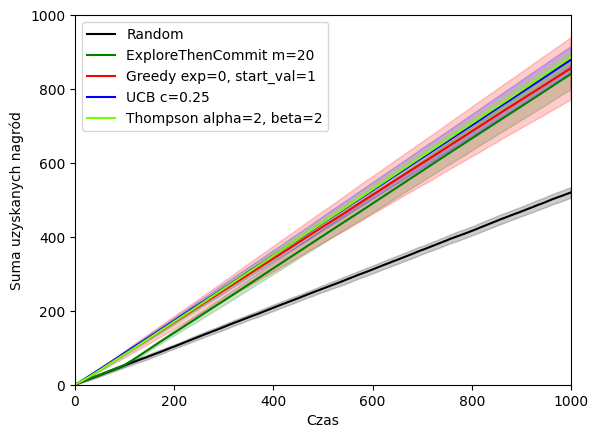

In [132]:
for learner in learners:
    evaluate_learner(learner)


plt.xlabel("Czas")
plt.ylabel("Suma uzyskanych nagród")
plt.xlim(0, TIME_STEPS)
plt.ylim(0, TIME_STEPS)
plt.legend()
plt.show()

In [21]:
POTENTIAL_HITS_V2 = {
    "April Showers": 0.5,
    "In Praise of Dreams": 0.8,
    "We Built This City": 0.9,
    "Twenty Four Hours": 0.3,
    "Dirge for November": 0.1,
    "Bohemian Rhapsody": 0.85,
    "Stairway to Heaven": 0.67,
    "Hotel California": 0.72,
    "Imagine": 0.58,
    "Sweet Child O' Mine": 0.64,
    "Billie Jean": 0.79,
    "Smells Like Teen Spirit": 0.63,
    "Yesterday": 0.45,
    "Like a Rolling Stone": 0.41,
    "Purple Haze": 0.38,
    "Born to Run": 0.48,
    "No Woman, No Cry": 0.47,
    "God Only Knows": 0.33,
    "A Day in the Life": 0.46,
    "Good Vibrations": 0.42,
    "London Calling": 0.31,
    "Blowin' in the Wind": 0.35,
    "I Want to Hold Your Hand": 0.39,
    "My Generation": 0.34,
    "Respect": 0.52,
    "Johnny B. Goode": 0.44,
    "What's Going On": 0.43,
    "Strawberry Fields Forever": 0.37,
    "Thunder Road": 0.32,
    "Waterloo Sunset": 0.29,
    "Superstition": 0.51,
    "Dancing Queen": 0.56,
    "Bridge Over Troubled Water": 0.49,
    "River Deep, Mountain High": 0.36,
    "The Sound of Silence": 0.48,
    "I Heard It Through the Grapevine": 0.47,
    "Thriller": 0.55,
    "Sweet Dreams (Are Made of This)": 0.52,
    "Every Breath You Take": 0.46,
    "Like a Prayer": 0.45,
    "Vogue": 0.44,
    "Creep": 0.43,
    "Wonderwall": 0.51,
    "Bitter Sweet Symphony": 0.42,
    "Karma Police": 0.39,
    "Song 2": 0.35,
    "Mr. Brightside": 0.48,
    "Seven Nation Army": 0.52,
    "Crazy in Love": 0.54,
    "Hey Ya!": 0.56,
    "Paper Planes": 0.41,
    "Umbrella": 0.47,
    "Single Ladies": 0.49,
    "Rolling in the Deep": 0.58,
    "Get Lucky": 0.53,
    "Uptown Funk": 0.59,
    "Happy": 0.55,
    "Can't Stop the Feeling!": 0.51,
    "Shape of You": 0.57,
    "Despacito": 0.52,
        "Old Town Road": 0.76,
    "Bad Guy": 0.69,
    "Blinding Lights": 0.78,
    "Driver's License": 0.66,
    "Levitating": 0.71,
    "Heat Waves": 0.68,
    "Stay": 0.67,
    "As It Was": 0.75,
    "Unholy": 0.58,
    "Anti-Hero": 0.69,
    "Flowers": 0.72,
    "Last Night": 0.58,
    "Kill Bill": 0.66,
    "Creepin'": 0.62,
    "Die for You": 0.65,
    "Calm Down": 0.64,
    "Under the Influence": 0.57,
    "Bad Habit": 0.63,
    "Escapism": 0.53,
    "Rich Flex": 0.59,
    "Lift Me Up": 0.61,
    "Jaded": 0.54,
    "Cuff It": 0.67,
    "Golden Hour": 0.66,
    "Sure Thing": 0.58,
    "Nonsense": 0.52,
    "The Kind of Love We Make": 0.61,
    "You Proof": 0.56,
    "Rock and a Hard Place": 0.51,
    "Dark Red": 0.48,
    "Glimpse of Us": 0.67,
    "Until I Found You": 0.63,
    "Romantic Homicide": 0.49,
    "Something in the Orange": 0.61,
    "She Had Me at Heads Carolina": 0.57,
    "Going, Going, Gone": 0.52,
    "Wait in the Truck": 0.48,
    "Tennessee Whiskey": 0.66,
    "Vienna": 0.57,
    "Dreams": 0.71,
    "The Chain": 0.64,
    "Don't Stop Believin'": 0.82,
}